In [8]:
import numpy as np
import h5py
from merger_clean import *
from merger_rate import *
import matplotlib.pyplot as plt
import camb 
import matplotlib as mpl
import csv
import os
import pandas as pd 
from astropy.cosmology import LambdaCDM, z_at_value
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from scipy.optimize import curve_fit
params = {'legend.fontsize': 7,
          'legend.handlelength': 2}
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['font.family'] = 'serif'
plt.rcParams.update(params)

In [2]:
def mcbride_mah(z, gamma, beta):
    return (1+z)**beta*np.exp(-gamma*z)

In [3]:
fbase = '/home/painchess/sims/'
sim = 'm4s8'
om = 0.4
s8 = 0.8
reds = np.loadtxt(fbase+'mxsy_reds.txt')[::-1]

## CREATING THE USABLE SIM MAHS 

In [4]:
filenames = os.listdir(fbase+sim+'/mahs')
filenames.sort()

In [5]:
len(filenames)

529000

In [6]:
cosmo = LambdaCDM(H0=100*h, Om0=om, Ode0=1-om, Ob0=4e-2)
infall = 1.44/hubble_ratio(reds, omega_m0=om, omega_l0=1-om) #infall time in gyr
ages = cosmo.age(reds).value
age_after_infall = ages+infall
zedprime = []
for j in range(12,len(ages)):
    zedprime.append(z_at_value(cosmo.age, age_after_infall[j]*u.Gyr))

zprime= []
myreds = []
res= []
conc = []
ids = []
emptyfiles = []
for i in range(len(filenames)):
    if os.path.getsize(fbase+sim+'/mahs/'+filenames[i])>15000:  
        try:
            masses = np.loadtxt(fbase+sim+'/mahs/'+filenames[i])[:, 4]
            conc.append(np.loadtxt(fbase+sim+'/mahs/'+filenames[i])[:, 43][0])
            zprime.append(zedprime[:len(masses)-11])
            ids.append(np.loadtxt(fbase+sim+'/mahs/'+filenames[i])[:, 1][0])
            res.append(masses)
        except IndexError:
            a = 'do nothing'
    else:
        emptyfiles.append(filenames[i])
ares = np.array(res, dtype=object)
zprime = np.array(zprime, dtype=object)
conc = np.array(conc, dtype=object)
ids = np.array(ids, dtype=object)

(array([10639.,  7817.,  7962.,  6089.,  7984., 10197.,  8619.,  8525.,
         8835., 11111.,  9066., 11696., 11867.,  9544., 11607., 14600.,
        12319., 20681., 12366., 14618., 14570., 14095., 16282., 15812.,
        15164., 14500., 15321., 14255., 12872., 12783., 12117.,  9530.,
         7727.,  5460.,  5345.]),
 array([ 28.        ,  30.05714286,  32.11428571,  34.17142857,
         36.22857143,  38.28571429,  40.34285714,  42.4       ,
         44.45714286,  46.51428571,  48.57142857,  50.62857143,
         52.68571429,  54.74285714,  56.8       ,  58.85714286,
         60.91428571,  62.97142857,  65.02857143,  67.08571429,
         69.14285714,  71.2       ,  73.25714286,  75.31428571,
         77.37142857,  79.42857143,  81.48571429,  83.54285714,
         85.6       ,  87.65714286,  89.71428571,  91.77142857,
         93.82857143,  95.88571429,  97.94285714, 100.        ]),
 <BarContainer object of 35 artists>)

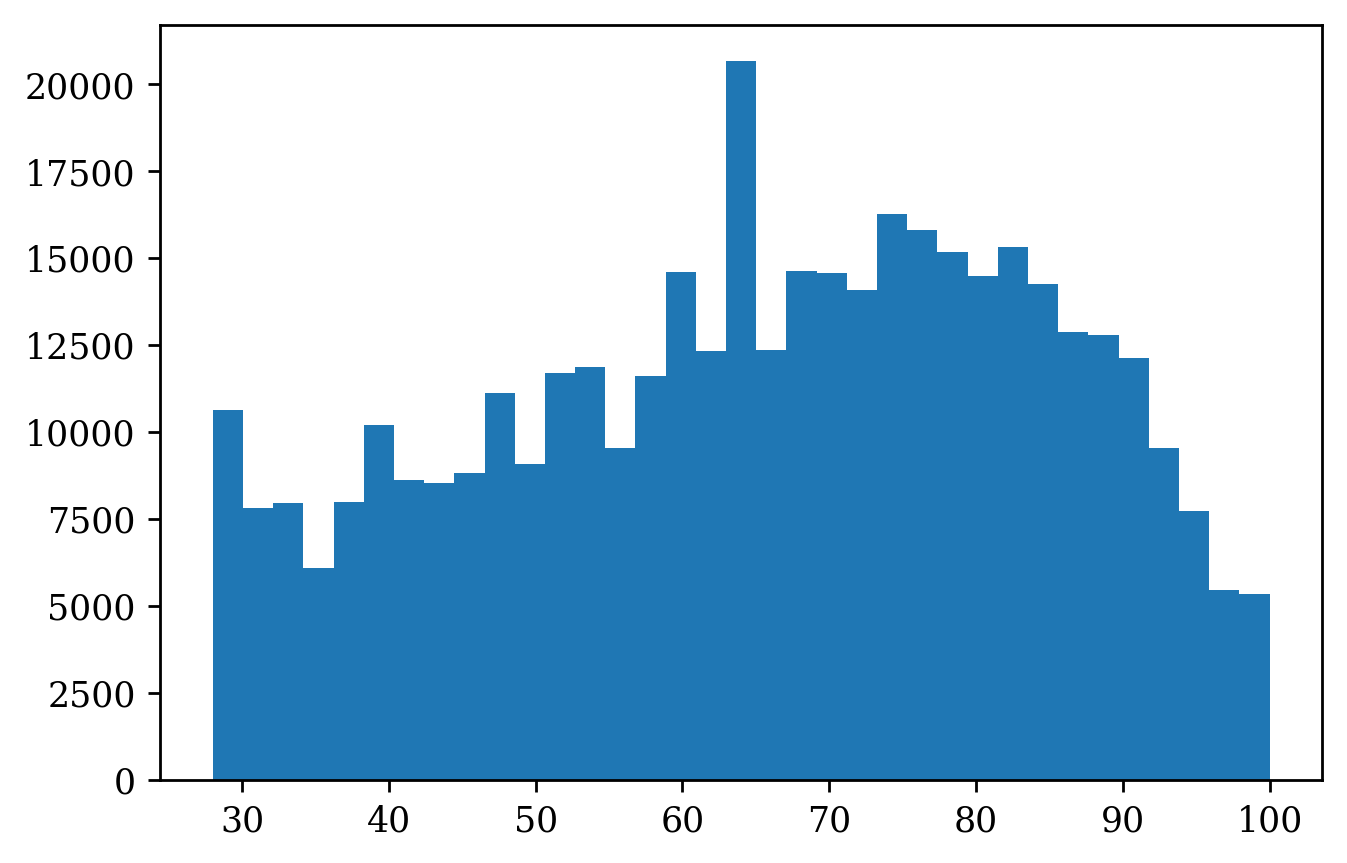

In [10]:
mah_length = []
for rs in res:
    mah_length.append(len(rs))
plt.hist(mah_length, bins = 35)

In [11]:
np.max(mah_length)

100

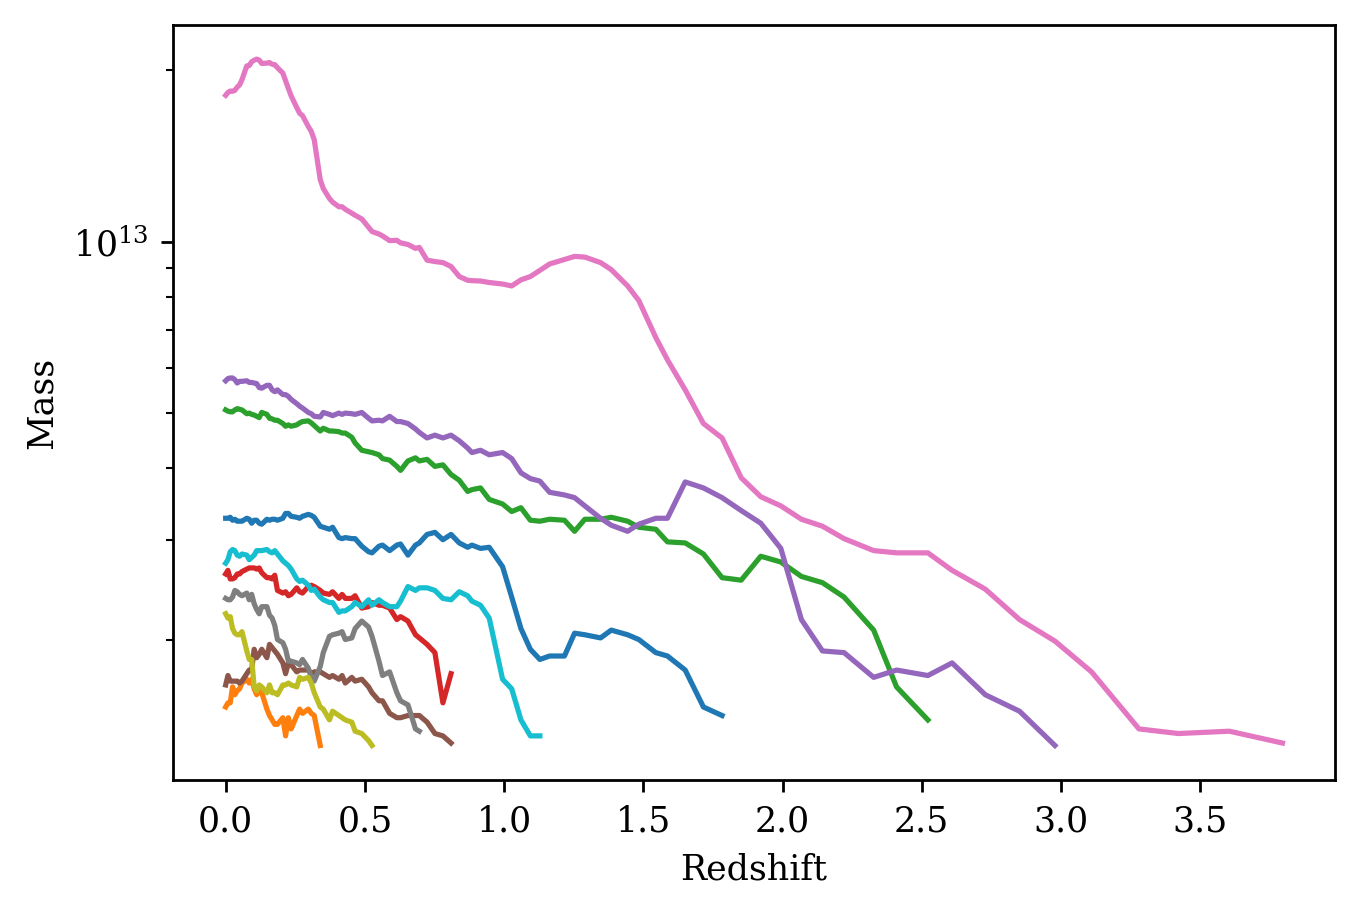

In [13]:
for i in range(10): 
    hal_N = np.random.randint(len(ares))
    plt.plot(reds[:len(ares[hal_N])], ares[hal_N])
    plt.yscale('log')
    plt.xlabel('Redshift')
    plt.ylabel('Mass')

In [14]:
np.save(fbase+sim+'/mahs_{}.npy'.format(sim), ares)
np.save(fbase+sim+'/conc_{}.npy'.format(sim), conc)
np.save(fbase+sim+'/ids_{}.npy'.format(sim), ids)

In [4]:
ares = np.load(fbase+sim+'/mahs_{}.npy'.format(sim), allow_pickle=True)
conc = np.load(fbase+sim+'/conc_{}.npy'.format(sim), allow_pickle=True)
nids = np.load(fbase+sim+'/ids_{}.npy'.format(sim), allow_pickle=True)

In [14]:
#Distribution of z_%  Illustris
start = 0
Nhalos = len(ares)
h=0.7



fracs = [0.01, 0.1, 0.5, 0.75, 0.9]
#frac=0.9
for frac in fracs:
    age_i = []
    indices_i = []

    Mmin = 1e12
    Mmax = 1e17
    mass_i = []
    zx_i = []
    for i in range(start, start+Nhalos):
        nmah = ares[i]
        if len(nmah)>0:
            m = nmah[0]
            zeds = reds[:len(nmah)]
            ids = np.where(nmah/nmah[0]<frac)
            #ids = np.where(nmah/np.max(nmah)<frac)
            if len(ids[0]) > 0:
                idx = np.min(np.where(nmah/nmah[0]<frac))
                #idx = np.max(np.where(nmah/np.max(nmah)>frac))
                zx = np.sqrt(zeds[idx]*zeds[idx-1])
                zx_i.append(zx)
                #age_il.append(np.sqrt(ages[idx]*ages[idx-1]))
                mass_i.append(m)
                indices_i.append(i)
            else :
                zx_i.append(0)
                mass_i.append(m)
                indices_i.append(i)
    
    #age_il = np.array(age_il)
    indices_i = np.array(indices_i)
    if frac == 0.5: 
        z50_i = np.array(zx_i)
    elif frac == 0.9:
        z90_i = np.array(zx_i)
    elif frac == 0.75:
        z75_i = np.array(zx_i)
    elif frac == 0.1:
        z10_i = np.array(zx_i)
    elif frac ==0.01:
        z1_i = np.array(zx_i)
mass_i = np.array(mass_i)

/usr/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/lib/python3.10/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


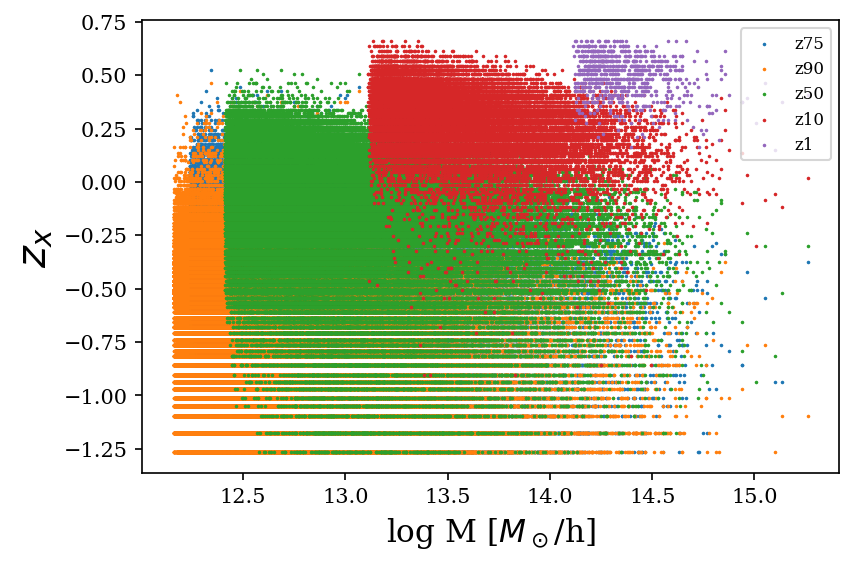

In [15]:
params = {'legend.fontsize': 8,
          'legend.handlelength': 2}
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
plt.rcParams.update(params)

plt.scatter(np.log10(mass_i[z75_i>0.05]), np.log10(z75_i[z75_i>0.05]), s=0.5, label = 'z75')
plt.scatter(np.log10(mass_i[z90_i>0.05]), np.log10(z90_i[z90_i>0.05]), s=0.5, label = 'z90')
plt.scatter(np.log10(mass_i[z50_i>0.05]), np.log10(z50_i[z50_i>0.05]), s=0.5, label = 'z50')
plt.scatter(np.log10(mass_i[z10_i>0.1]), np.log10(z10_i[z10_i>0.1]), s=0.5, label = 'z10')
plt.scatter(np.log10(mass_i[z1_i>0.1]), np.log10(z1_i[z1_i>0.1]), s=0.5, label = 'z1')

plt.xlabel('log M [$M_\odot$/h]', size=15)
plt.ylabel('$z_x$', size=20)
plt.legend()

Text(0.5, 0, '$z_{50}$')

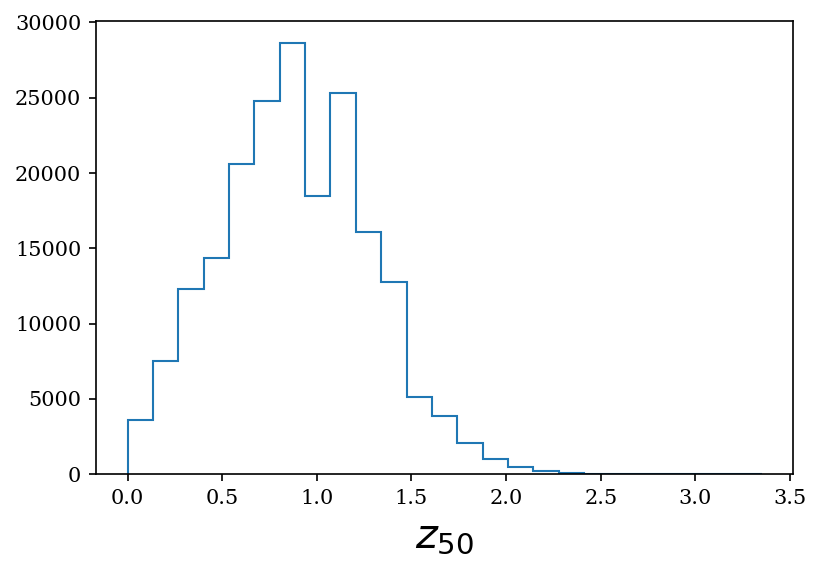

In [21]:
plt.hist(z50_i[z50_i>0], bins=25, histtype='step')
plt.xlabel(r'$z_{50}$', size=20)

Text(0.5, 0, '$z_{50}$')

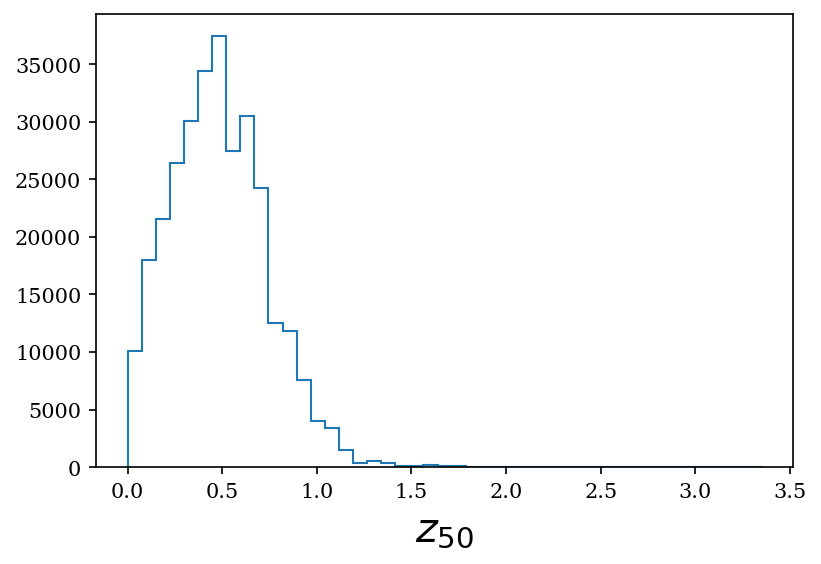

In [17]:
#plt.hist(np.log10(1+z75_i[z75_i>0]), bins=45, histtype='step')
plt.hist(z75_i[z75_i>0], bins=45, histtype='step')
plt.xlabel(r'$z_{50}$', size=20)

## SAVING z_i 

In [15]:
sims = ['m3s9', 'm2s1']
for sim in sims:
    mah = np.load(fbase+sim+'/mahs_{}.npy'.format(sim), allow_pickle=True)
    #idx = np.load(fbase+sim+'/ids_{}.npy'.format(sim), allow_pickle=True)
    conc = np.load(fbase+sim+'/conc_{}.npy'.format(sim), allow_pickle=True)
    #zs = np.load(mah_dir+'z_{}.npy'.format(prefix), allow_pickle=True)
    start = 0
    Nhalos = len(mah)
    h=0.7
    c = []
    zx_i = ([], [], [], [], [])
    mass_i = []
    fracs=[0.9, 0.75, 0.5, 0.1, 0.01]
    age_i = []
    indices_i = []
    gamma, beta =[] , []
    Mmin = 1e12
    Mmax = 1e17
    for i in range(start, start+Nhalos):
        nmah = mah[i]
        zeds = reds[:len(nmah)]
        m = nmah[0]
        if len(nmah)>5:
            for j in range(len(fracs)):
                frac = fracs[j]
                ids = np.where(nmah/nmah[0]<frac)
                if len(ids[0]) > 0:
                    idx = np.min(np.where(nmah/nmah[0]<frac))
                    zx = np.sqrt(zeds[idx]*zeds[idx-1])
                    zx_i[j].append(zx)
                    #age_il.append(np.sqrt(ages[idx]*ages[idx-1]))
                else :
                    zx_i[j].append(0)
            try:
                param, cov = curve_fit(mcbride_mah, zeds, nmah)
                gamma.append(param[0])
                beta.append(param[1])
            except RuntimeError:
                gamma.append(-1e50)
                beta.append(-1e50)
            mass_i.append(m)
            indices_i.append(i)
            c.append(conc[i])
    mass_i = np.array(mass_i)
    indices_i = np.array(indices_i)
    c = np.array(c)
    #age_il = np.array(age_il)

    towrite = Table([zx_i[0], zx_i[1],zx_i[2],zx_i[3],zx_i[4], gamma, beta, mass_i, c, indices_i], names=['z90','z75','z50','z10','z1', 'McBribe gamma', 'McBride beta', 'Mass', 'Concentratio', 'Halo index'])
    #ascii.write(towrite, '{}_zx.ecsv'.format(prefix), format='ecsv', overwrite=True)
    ascii.write(towrite, fbase+sim+'/{}_zx.dat'.format(sim), overwrite=True)

/usr/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [20]:
sims = ['m25s85', 'm2s8', 'm4s7', 'm2s9', 'm3s8', 'm35s75', 'm4s9', 'm3s9', 'm25s75', 'm2s1']
fracs=['z90','z75','z50','z10','z1']
zx_arr = np.zeros((len(sims), len(fracs)))
for i in range(len(sims)):
    data = ascii.read(fbase+sims[i]+'/{}_zx.dat'.format(sims[i]))
    for j in range(len(fracs)):
        arr = np.array(data[fracs[j]])
        zx_arr[i,j] = np.median(arr[arr>0])


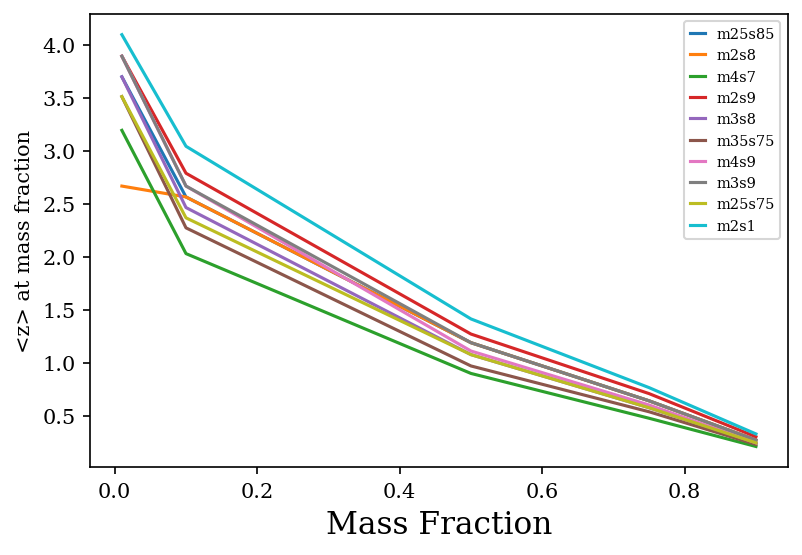

In [21]:
params = {'legend.fontsize': 7,
          'legend.handlelength': 1}
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'

plt.rcParams.update(params)
nfracs=[0.9, 0.75, 0.5, 0.1, 0.01]
for i in range(len(sims)):
    plt.plot(nfracs, zx_arr[i, :], label=sims[i])
plt.legend()
plt.xlabel('Mass Fraction', size=15)
plt.ylabel('<z> at mass fraction', size=10)
plt.savefig('zx_vs_x.png', facecolor='white', transparent=True, dpi=300)